In [1]:
from datetime import datetime
from pathlib import Path
from typing import Any, Final, Optional, TypeAlias, TypedDict, Union, cast
from dataclasses import dataclass

import cv2
import numpy as np
import orjson
import trimesh
from beartype import beartype
from cv2 import aruco
from cv2.typing import MatLike
from jaxtyping import Float, Int, Num, jaxtyped
from loguru import logger
from matplotlib import pyplot as plt
from numpy.typing import ArrayLike
from numpy.typing import NDArray as NDArrayT

NDArray: TypeAlias = np.ndarray

In [2]:
INPUT_IMAGE = Path("merged_uv_layout.png")
# 7x7
# DICTIONARY: Final[int] = aruco.DICT_7X7_1000
DICTIONARY: Final[int] = aruco.DICT_APRILTAG_36H11
# 400mm
MARKER_LENGTH: Final[float] = 0.4

In [3]:
aruco_dict = aruco.getPredefinedDictionary(DICTIONARY)
detector = aruco.ArucoDetector(
    dictionary=aruco_dict, detectorParams=aruco.DetectorParameters()
)

In [4]:
frame = cv2.imread(str(INPUT_IMAGE))
assert frame is not None
grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
# pylint: disable-next=unpacking-non-sequence
markers, ids, rejected = detector.detectMarkers(grey)

In [5]:
# Note: BGR
RED = (0, 0, 255)
GREEN = (0, 255, 0)
BLUE = (255, 0, 0)
YELLOW = (0, 255, 255)
GREY = (128, 128, 128)
CYAN = (255, 255, 0)
MAGENTA = (255, 0, 255)
ORANGE = (0, 165, 255)
PINK = (147, 20, 255)

UI_SCALE = 10
UI_SCALE_FONT = 8
UI_SCALE_FONT_WEIGHT = 20

In [6]:
out = frame.copy()
# `markers` is [N, 1, 4, 2]
# `ids` is [N, 1]
if ids is not None:
    markers = np.reshape(markers, (-1, 4, 2))
    ids = np.reshape(ids, (-1, 1))
    # logger.info("markers={}, ids={}", np.array(markers).shape, np.array(ids).shape)
    for m, i in zip(markers, ids):
        # logger.info("id={}, center={}", i, center)
        center = np.mean(m, axis=0).astype(int) # type: ignore
        # BGR
        color_map = [RED, GREEN, BLUE, YELLOW]
        for color, corners in zip(color_map, m):
            corners = corners.astype(int)
            out = cv2.circle(out, corners, 5*UI_SCALE, color, -1)
        cv2.circle(out, tuple(center), 5*UI_SCALE, CYAN, -1)
        cv2.putText(
            out,
            str(i),
            tuple(center),
            cv2.FONT_HERSHEY_SIMPLEX,
            1*UI_SCALE_FONT,
            MAGENTA,
            UI_SCALE_FONT_WEIGHT,
        )

In [7]:
@jaxtyped(typechecker=beartype)
@dataclass
class Marker:
    id: int
    center: Num[NDArray, "2"]
    corners: Num[NDArray, "4 2"]


output_markers: list[Marker] = []
if ids is not None:
    assert frame is not None
    IMAGE_WIDTH = frame.shape[1]
    IMAGE_HEIGHT = frame.shape[0]

    def normalize_point(point: NDArrayT[Any]) -> NDArrayT[np.float64]:
        """
        input could be: [N, 2] or [2]
        """
        if point.ndim == 1:
            return point / np.array([IMAGE_WIDTH, IMAGE_HEIGHT])
        elif point.ndim == 2:
            return point / np.array([IMAGE_WIDTH, IMAGE_HEIGHT])
        else:
            raise ValueError(f"Invalid shape: {point.shape}")

    def flip_y(point: NDArrayT[Any], y_max: int) -> NDArrayT[Any]:
        """
        flip y axis;

        Usually OpenCV image y-axis is inverted. (origin at top-left)
        In UV layout, the origin is at bottom-left.
        """
        return np.array([point[0], y_max - point[1]])

    for m, i in zip(markers, ids):
        center = np.mean(m, axis=0).astype(int)  # type: ignore
        output_markers.append(
            Marker(
                id=int(i[0]),
                center=flip_y(normalize_point(center), 1),
                corners=np.array([flip_y(normalize_point(c), 1) for c in m]),
            )
        )

with open("output/aruco_2d_uv_coords_normalized.json", "wb") as f:
    f.write(orjson.dumps(output_markers, option=orjson.OPT_SERIALIZE_NUMPY))

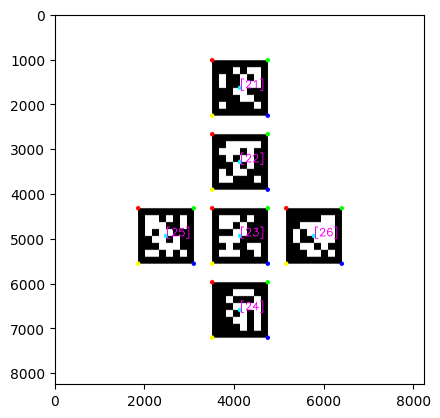

In [8]:
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))

In [9]:
cv2.imwrite("merged_uv_layout_with_markers.png", out)

True

In [10]:
import trimesh.visual


@jaxtyped(typechecker=beartype)
def interpolate_uvs_to_3d(
    uv_points: Num[NDArray, "N 2"],
    vertices: Num[NDArray, "V 3"],
    uvs: Num[NDArray, "V 2"],
    faces: Num[NDArray, "F 3"],
    epsilon: float = 1e-6,
) -> Num[NDArray, "N 3"]:
    """
    Map multiple UV points to 3D coordinates using barycentric interpolation.

    Args:
        uv_points: (N, 2) array of UV coordinates in [0,1]
        vertices: (V, 3) array of mesh vertex positions
        uvs:      (V, 2) array of per-vertex UV coordinates
        faces:    (F, 3) array of triangle vertex indices
        epsilon:  barycentric inside-triangle tolerance

    Returns:
        (N, 3) array of interpolated 3D coordinates (NaNs if no triangle found)
    """
    results = np.full((uv_points.shape[0], 3), np.nan, dtype=np.float64)

    for pi, uv_point in enumerate(uv_points):
        for face in faces:
            uv_tri = uvs[face]  # (3,2)
            v_tri = vertices[face]  # (3,3)

            A = np.array(
                [
                    [uv_tri[0, 0] - uv_tri[2, 0], uv_tri[1, 0] - uv_tri[2, 0]],
                    [uv_tri[0, 1] - uv_tri[2, 1], uv_tri[1, 1] - uv_tri[2, 1]],
                ]
            )
            b = uv_point - uv_tri[2]

            try:
                w0, w1 = np.linalg.solve(A, b)
                w2 = 1.0 - w0 - w1
                if min(w0, w1, w2) >= -epsilon:
                    results[pi] = w0 * v_tri[0] + w1 * v_tri[1] + w2 * v_tri[2]
                    break  # Stop after first matching triangle
            except np.linalg.LinAlgError:
                continue

    return results


@jaxtyped(typechecker=beartype)
def interpolate_uvs_to_3d_trimesh(
    uv_points: Num[NDArray, "N 2"],
    mesh: Union[trimesh.Trimesh, trimesh.Scene],
    epsilon: float = 1e-6,
) -> Num[NDArray, "N 3"]:
    """
    Wrapper for batched UV-to-3D interpolation using a trimesh mesh or scene.

    Args:
        uv_points: (N, 2) UV coordinates to convert
        mesh: a Trimesh or Scene object
        epsilon: barycentric epsilon tolerance

    Returns:
        (N, 3) array of 3D positions (NaN if outside mesh)
    """
    if isinstance(mesh, trimesh.Scene):
        if len(mesh.geometry) == 0:
            raise ValueError("Scene has no geometry.")
        mesh = list(mesh.geometry.values())[0]

    if not isinstance(mesh, trimesh.Trimesh):
        raise TypeError("Expected a Trimesh or Scene with geometry.")

    if mesh.visual is None:
        raise ValueError("Mesh does not have visual.")
    visual = cast(trimesh.visual.TextureVisuals, mesh.visual)

    if visual.uv is None:
        raise ValueError("Mesh does not have UVs.")

    return interpolate_uvs_to_3d(
        uv_points=uv_points,
        vertices=mesh.vertices,
        uvs=visual.uv,
        faces=mesh.faces,
        epsilon=epsilon,
    )

In [11]:
m = trimesh.load_mesh("sample/standard_box.glb")
def marker_to_3d_coords(marker: Marker, mesh: trimesh.Trimesh):
    uv_points = marker.corners
    return interpolate_uvs_to_3d_trimesh(uv_points, mesh)

id_to_3d_coords = {marker.id: marker_to_3d_coords(marker, m) for marker in output_markers}
# note that the glb is Y up
# when visualizing with matplotlib, it's Z up
OPEN_GL_TO_BLENDER = np.array([[1, 0, 0], [0, 0, -1], [0, 1, 0]])
display(np.linalg.inv(OPEN_GL_TO_BLENDER)) # should be the same

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [-0., -1., -0.]])

In [12]:
# matplotlib default colors scheme
colors: list[str] = plt.rcParams["axes.prop_cycle"].by_key()["color"]

def hex_to_rgb(hex_color: str) -> tuple[float, float, float]:
    assert hex_color.startswith("#")
    assert len(hex_color) == 7
    return tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5)) # type: ignore

In [ ]:
from functools import lru_cache
from typing import Optional, TypedDict
import awkward as ak


class MarkerFace(TypedDict):
    name: str
    ids: Int[NDArray, "N"]
    """
    ArUco marker ids
    """
    corners: Num[NDArray, "N 4 3"]
    """
    Corner coordinates in 3D of rectangle,
    relative to the world origin
    """


@dataclass
class Face:
    color: tuple[float, float, float]
    marker_ids: list[int]


# fmt: off
layout:list[list[Optional[int]]] = [
    [None, None, 0, None, None],
    [None, None, 1, None, None],
    [None,    5, 2,    4, None],
    [None, None, 3, None, None],
]
# fmt: on

# only one marker per face
faces = {
    "bottom": Face(color=hex_to_rgb(colors[0]), marker_ids=[21]),
    "back": Face(color=hex_to_rgb(colors[1]), marker_ids=[22]),
    "top": Face(color=hex_to_rgb(colors[2]), marker_ids=[23]),
    "front": Face(color=hex_to_rgb(colors[3]), marker_ids=[24]),
    "right": Face(color=hex_to_rgb(colors[4]), marker_ids=[26]),
    "left": Face(color=hex_to_rgb(colors[5]), marker_ids=[25]),
}

markers: list[MarkerFace] = []
for name, face in faces.items():
    corners = np.array([id_to_3d_coords[id] for id in face.marker_ids])
    assert corners.shape == (1, 4, 3)
    markers.append(MarkerFace(name=name, ids=np.array(face.marker_ids), corners=corners))
display(markers)

ak.to_parquet(markers, "output/standard_box_markers.parquet")

[{'name': 'bottom',
  'ids': array([21]),
  'corners': array([[[-0.75105877, -1.        ,  0.75428318],
          [ 0.74963293, -1.        ,  0.75428407],
          [ 0.74963293, -1.        , -0.74640606],
          [-0.75105877, -1.        , -0.74640695]]])},
 {'name': 'back',
  'ids': array([22]),
  'corners': array([[[-0.75105877, -0.752554  , -1.        ],
          [ 0.74963293, -0.7525549 , -1.        ],
          [ 0.74963293,  0.74813658, -1.        ],
          [-0.75105832,  0.74813703, -1.        ]]])},
 {'name': 'top',
  'ids': array([23]),
  'corners': array([[[-0.75105825,  1.        , -0.75082408],
          [ 0.749633  ,  1.        , -0.75082452],
          [ 0.749633  ,  1.        ,  0.74986561],
          [-0.75105825,  1.        ,  0.74986561]]])},
 {'name': 'front',
  'ids': array([24]),
  'corners': array([[[-0.75105795,  0.74909564,  1.        ],
          [ 0.7496333 ,  0.74909564,  1.        ],
          [ 0.74963509, -0.75159404,  1.        ],
          [-0.751

  created_by: parquet-cpp-arrow version 23.0.0
  num_columns: 3
  num_rows: 6
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

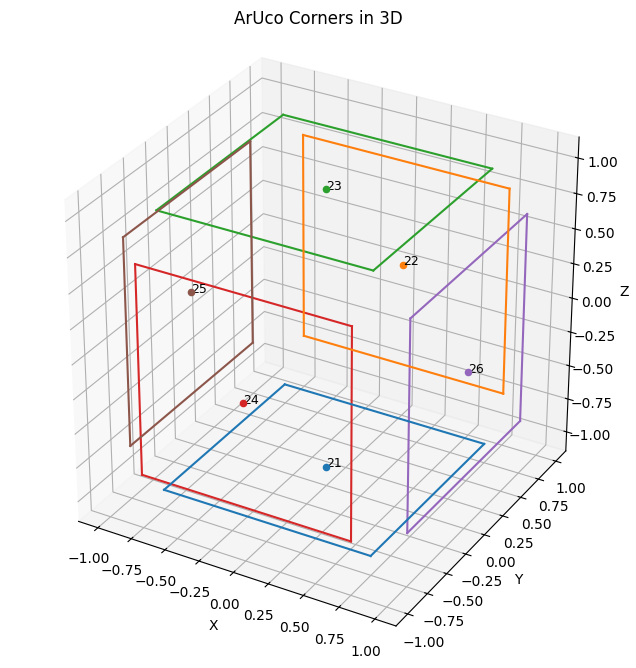

In [16]:
@lru_cache
def get_face_by_marker_id(marker_id: int) -> Optional[Face]:
    for face in faces.values():
        if marker_id in face.marker_ids:
            return face
    return None


# 3D Visualization (with flipped and fully valid data)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

for tag_id, corners in id_to_3d_coords.items():
    corners = np.array(corners)
    face = get_face_by_marker_id(tag_id)
    assert face is not None
    color = face.color
    for i in range(4):
        p1 = OPEN_GL_TO_BLENDER @ corners[i]
        p2 = OPEN_GL_TO_BLENDER @ corners[(i + 1) % 4]
        ax.plot(*zip(p1, p2), color=color)
    center = OPEN_GL_TO_BLENDER @ corners.mean(axis=0)
    ax.scatter(*center, color=color)
    ax.text(*center, str(tag_id), fontsize=9, color="black")  # type: ignore

ax.set_box_aspect([1, 1, 1])  # type: ignore
ax.set_title("ArUco Corners in 3D")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")  # type: ignore

# Set the viewing angle
# ax.view_init(elev=60, azim=35) # type: ignore

plt.show()